In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

""" TO-DO:
- Plot expected precession period

QUESTIONS:
- Number of samples??
"""

G = 6.67e-11 # G in SI units ****
mSun = 1.9891e30 # mass of sun in kg ****
AU_TO_M = 1.496e+11 # meters in one AU

# Check accuracy of all the following constants
mSat = 0.0002857 # mass of saturn in solar masses
aSat = 9.5549 # semi-major axis of Saturn's orbit in AU
eSat = 0.0565 # eccentricity of Saturn
rSat = 0.00038926024 # radius of Saturn in AU
j2Sat = 16298e-6 # J2 of Saturn (Murray and Dermott p 531) 
curr_aTitan = 0.008167696467 # modern-day semi-major axis of titan in AU
mTitan = 0.0000000676319759 # mass of titan in solar masses
eTitan = 0.001 # eccentricity of Titan's orbit ***** Modify as needed *****
iTitan = 0.34854 * np.pi / 180 # inclination of titan's orbit in radians

ini_aTitan = 8.212 * rSat  # starting semi-major axis of Titan

# Calculate the expected semi-major axis of Titan at which evection resonance should occur given i = e = 0

exp_aRes = np.power((9/4)*j2Sat*j2Sat*mSat*(aSat/rSat)**3, (1/7)) # in units of saturn radii

print(str(exp_aRes) + " Saturn radii")


8.215180272431718 Saturn radii


In [2]:
# Calculate expected precession period for initial semi-major axis of Titan
# given i = e = 0 (eqn (3) Spalding_et_al_2016.pdf)
# using a, semi-major axis, as orbital radius

aTitan = ini_aTitan
mean_motion_Titan = np.sqrt(G*mSat*mSun / ((aTitan*AU_TO_M)**3)) # mean motion of titan in radians per second

# convert to radians per year
mean_motion_year = mean_motion_Titan * 3600*24*365.25

# mean_motion_year seems accurate assuming correct units
# I checked with sim.particles[1].n and it is off by less than .2

exp_prec_freq = (3/2)*mean_motion_year*j2Sat*(rSat**2)/(aTitan**2) # in radians per year
exp_prec_T = 2*np.pi/exp_prec_freq # in years per revolution
print(str(exp_prec_T) + " years")


29.500728095356823 years


In [3]:
# calculate period of Titan in years at evection resonance distance ** Check accuracy **
mm = np.sqrt(G*mSat*mSun / ((exp_aRes*rSat*AU_TO_M)**3))  # in rad / sec
tauTitan = 2*np.pi*(1/mm)/(3600*24*365.25) # in years
print(str(tauTitan)+" years")


0.010700711659839537 years


In [4]:
# Calculate timescale for exponential migration of Titan's semi-major axis

ageSat = 4.503e9 # age of saturn in yrs
timescale = 3 * ((exp_aRes*rSat/curr_aTitan)**3) * ageSat

print(str(timescale) + " years")

810766627.6731131 years


329.53939414024353 seconds


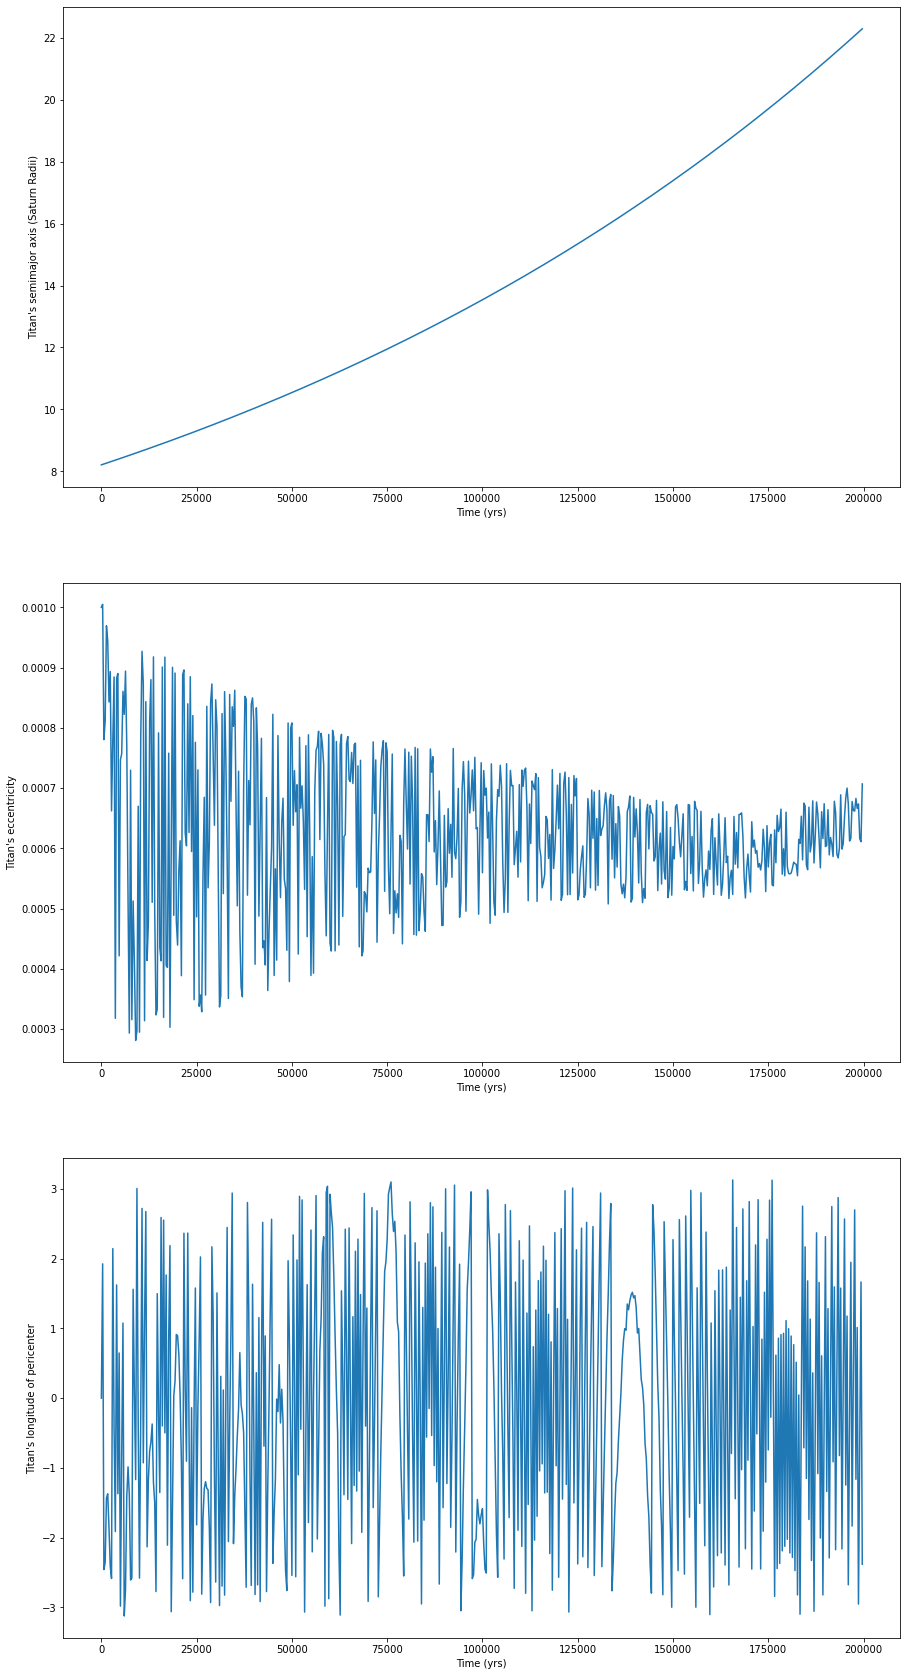

In [21]:
import time

start_time = time.time()

numSamples = 600
totalSimTime = 200000
plotDT = totalSimTime/numSamples

# Initialize rebound simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')

e_array = [0] * numSamples
a_array = [0] * numSamples
pomega_array = [0] * numSamples
time_array = [0] * numSamples

# add Saturn
sim.add(m=mSat)

# add Titan
sim.add(m=mTitan, a=ini_aTitan, e=eTitan)

# add sun (with semi-major axis and eccentricity of Saturn)
sim.add(m=1, a=aSat, e=eSat)

rebx = reboundx.Extras(sim) # Initiate reboundx

# Add migration force for Titan's outward migration (a = a0e^(t/tau)
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)
sim.particles[1].params["tau_a"] = timescale

# Add the exponential migration force
#mod_effect = rebx.load_force("exponential_migration") 
#rebx.add_force(mod_effect)
#sim.particles[1].params["em_aini"] = ini_aTitan  # parameter 1: Titan's initial semimajor axis
#sim.particles[1].params["em_afin"] = curr_aTitan  # parameter 2: Titan's final semimajor axis
#sim.particles[1].params["em_tau_a"] = timescale  # parameter 3: the migration e-folding time

# add Saturn's J2
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)
sim.particles[0].params["J2"] = j2Sat
sim.particles[0].params["R_eq"] = rSat

sim.integrator = "whfast"
sim.dt = (1/20) * tauTitan # time step = 1/20 * shortest orbital period

for i in range(0,numSamples):   # Integrate the system for 1e4 years
    sim.integrate(i * plotDT)
    a_array[i] = sim.particles[1].a / rSat
    e_array[i] = sim.particles[1].e
    pomega_array[i] = sim.particles[1].pomega
    time_array[i] = sim.t

sim.move_to_hel()

# check if Titan collided with Saturn
# check if Titan passed Roche limit

fig, axs = plt.subplots(3)

fig.set_size_inches(15, 30)

axs[0].plot(time_array,a_array)
axs[0].set_xlabel('Time (yrs)')
axs[0].set_ylabel('Titan\'s semimajor axis (Saturn Radii)')

axs[1].plot(time_array,e_array)
axs[1].set_xlabel('Time (yrs)')
axs[1].set_ylabel('Titan\'s eccentricity')

axs[2].plot(time_array,pomega_array)
axs[2].set_xlabel('Time (yrs)')
axs[2].set_ylabel('Titan\'s longitude of pericenter')

print(str(time.time() - start_time) + " seconds")


# exp_pomega = [0] * numSamples
# for i in range(numSamples):
#     exp_pomega[i] = exp_prec_freq * time_array[i] + pomega_array[0]
    
# axs[3].plot(time_array, exp_pomega)
# axs[3].set_xlabel('Time (yrs)')
# axs[3].set_ylabel('Titan\'s expected longitude of pericenter')

# fig = rebound.OrbitPlot(sim, unitlabel="[AU]", color=False, periastron=True)

# ax = plt.subplot(111)
# ax.set_xlim([-.05,.05])
# ax.set_ylim([-.05,.05])

# plt.show()